In [2]:
import bokeh.charts as bc
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import requests
import qgrid
import seaborn as sns
from IPython.display import Image
from scipy.stats import pearsonr

%matplotlib inline
qgrid.nbinstall()

### The purpose of this notebook is to document data analysis for a [Reproducibility Study](https://osf.io/ezcuj/wiki/home/?_ga=1.257932747.1792380294.1420926336) conducted in collaboration with the [Center for Open Science](https://cos.io) and fulfillment of my [undergraduate thesis](https://osf.io/3k4uy/) at Reed College.

###The original article was ["Errors are aversive: defensive motivation and the error-related negativity."](http://www.ncbi.nlm.nih.gov/pubmed/18271855)

In [3]:
data = pd.read_csv("rp.csv")

In [4]:
qgrid.show_grid(data, remote_js=True)

In [15]:
# subset trials depending on whether participant made an error,
# made an error in the previous trial ('predict'), or
# was correct in current and previous trial ('unpred')
error_trials = data[data['startle_type'] == 'error']
pred_trials = data[data['startle_type'] == 'predict']
unpred_trials = data[data['startle_type'] == 'unpred']

In [16]:
# restructure dataframe for python analysis
pred_error = pd.merge(error_trials, pred_trials, how="outer", on=["participant","gender","ERN","EPS","errors"], suffixes=('_error', '_pred'))

In [17]:
# further restructuring
final = pd.merge(pred_error, unpred_trials, how="outer", on=["participant","gender","ERN","EPS","errors"], suffixes=('_', '_unpred'))

In [18]:
final.rename(columns={'startle':'startle_unpred','startle_peak':'startle_peak_unpred'},inplace=True)

In [19]:
# drop superfluous columns naming startle type
final.drop(['startle_type_error','startle_type_pred','startle_type'], axis=1, inplace=True)

In [20]:
# na in participant 21's unpred startle trial excludes it from some analyes
error_trial = error_trials[error_trials.participant != 21]
pred_trials = pred_trials[pred_trials.participant != 21]
unpred_trials = unpred_trials[unpred_trials.participant != 21]

In [25]:
final = final[final.participant != 21]

In [26]:
# mean error-potentiated startle (EPS) amplitude
round(final['EPS'].mean(),2)

3.3

In [27]:
#standard error of the mean
round(stats.sem(final['EPS']),2)

1.26

In [28]:
# mean difference between error and correct trials
(final['startle_error'] - final['startle_unpred']).mean()

2.4380758780487803

In [29]:
round(stats.sem(final['startle_error'] - final['startle_unpred']),2)

1.17

In [31]:
#main finding using one trial type for appropriate DF
corr_data = data[['ERN','EPS']]
corr_data.corr(method='pearson', min_periods=1)

,ERN,EPS
ERN,1.000000,-0.253099
EPS,-0.253099,1.000000


# calculation of ERN from correct vs error ERPs

In [33]:
correct = pd.read_csv('data/rep_Cor_all.txt',delim_whitespace=True)
incorrect = pd.read_csv('data/rep_Inc_All.txt',delim_whitespace=True)

In [34]:
correct['File'] = correct['File'].apply(lambda x: x.translate(None, '_repCor'))
incorrect['File'] = incorrect['File'].apply(lambda x: x.translate(None, '_repInc'))
incorrect = incorrect[['File','2-rep_Inc']]
correct = correct[['File','2-rep_Cor']]

In [35]:
erp = pd.merge(correct, incorrect, on='File')

In [36]:
erp.rename(columns={'File':'participant','2-rep_Cor':'correct','2-rep_Inc':'error'},inplace=True)

In [37]:
erp['participant'] = erp['participant'].apply(lambda x: int(x))

In [38]:
erp['ERN'] = erp['error']-erp['correct']

In [39]:
erp.sort('participant',inplace=True)

In [100]:
# difference between ERPs on correct vs error trials
stats.ttest_rel(erp['correct'], erp['error'])

(8.6910940198988254, 7.6108247487161248e-11)

In [41]:
#mean ERN amplitude
round((erp['error'] - erp['correct']).mean(),2)

-6.36

In [43]:
# ERN amplitude SEM
round(stats.sem(erp['error'] - erp['correct']),2)

0.73

### The main finding of the article replicated is A in the following figure.

In [44]:
Image(url="http://www.frontiersin.org/files/Articles/82577/fnhum-08-00064-HTML/image_m/fnhum-08-00064-g001.jpg")

### I failed to replicate this finding:

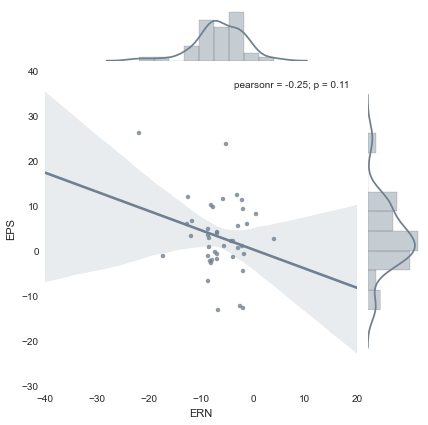

In [45]:
sns.jointplot(error_trials['ERN'],error_trials['EPS'],kind="reg",stat_func=pearsonr, color = "slategray")

However, the original author also found a more robust subsequent finding by dividing participants along median ERN and assessing correlation among those whose amplitudes were relatively high. We performed the same

In [46]:
high_amplitude = final[final['ERN'] < -6.91]

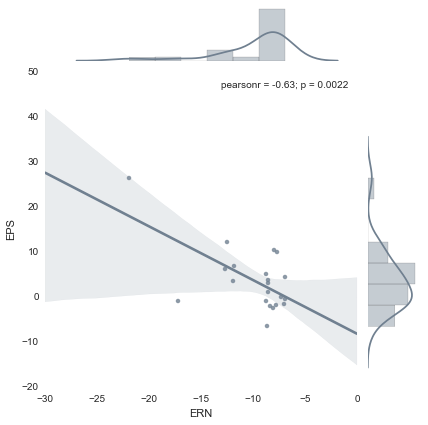

In [47]:
sns.jointplot(high_amplitude['ERN'],high_amplitude['EPS'],kind="reg",stat_func=pearsonr, color = "slategray")

and also found greater significance (greater correlation, *p* < .05) However, to investigate whether the outlier participant 1 had any bearing, we removed that data and reran the analysis:

In [48]:
high_amp_san_outlier = high_amplitude[high_amplitude['participant'] != 1]

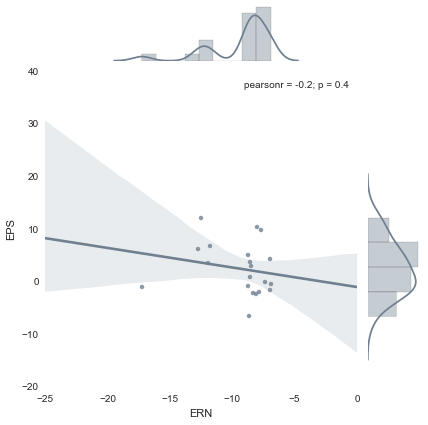

In [49]:
sns.jointplot(high_amp_san_outlier['ERN'],high_amp_san_outlier['EPS'],kind="reg",stat_func=pearsonr, color = "slategray")

and found the correlation diminished again.

The original author was communicative and eager to compare findings, and so offered his original ERN and EPS data to pool with our own:

In [53]:
collaboration = pd.read_csv('data/collaboration.csv')

In [54]:
collaboration.rename(columns={'ERN (window difference wave)':'ERN','Error-potentiated startle':'EPS'},inplace=True)

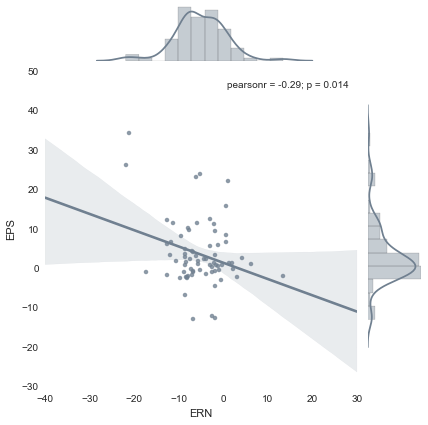

In [55]:
sns.jointplot(collaboration['ERN'],collaboration['EPS'],kind="reg",stat_func=pearsonr, color = "slategray")

The correlation is present here, *p* < .05, but by coincidence we each had one participant with unusually high ERN amplitudes. We analyzed the correlation with these removed:

In [57]:
collab_sans_outlier = collaboration[collaboration['ERN'] > -20]

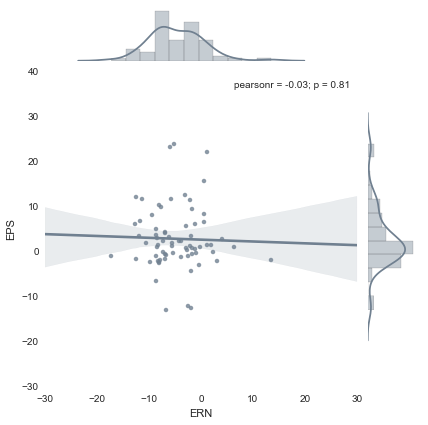

In [58]:
plot = sns.jointplot(collab_sans_outlier['ERN'],collab_sans_outlier['EPS'],kind="reg",stat_func=pearsonr, color = "slategray")

and the correlation is no longer present. It could be the case that the correlation is weak but real (and strong in 1 out of every 40 subjects), or it could be the case that in any sample of 40 subjects, random noise will cause at least one subject to show abnormally large ERN and EPS magnitudes, thereby strongly influencing the statistical relationship between these two variables.

We thank the original author Dr. Hajcak for providing input throughout the project. Quality replications are typically only possible with close correspondence with the original authors and we appreciate the willingness of Dr. Hajcak to contribute to this replication attempt.